### CNN 배경
- 기존 flatten화시켜 Input 해주었던 방식은 이미지 픽셀 값이 서로 독립적이지 않기 때문에 Region Feature를 학습하지 못 함
- Convolution Layer의 Receptive Field를 활용하여 Region Feature의 Weight 선형결합으로 학습할 수 있도록 함

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
    
BATCH_SIZE = 32
EPOCHS = 10

In [3]:
train_dataset = datasets.CIFAR10(root = '../data/FashionMNIST',
                                      train = True,
                                      download = True,
                                      transform = transforms.Compose([
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # normalize std for r,g,b
                                      ]))
test_dataset = datasets.CIFAR10(root = '../data/FashionMNIST',
                                      train = False,
                                      transform = transforms.Compose([
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # normalize std for r,g,b
                                      ]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [4]:
for (X_train, y_train) in train_loader: # X ~ matrix, y~vector
    print('X_train : ', X_train.size(),' ', X_train.type() )
    print('y_train : ', y_train.size(),' ', y_train.type() )
    break

X_train :  torch.Size([32, 3, 32, 32])   torch.FloatTensor
y_train :  torch.Size([32])   torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

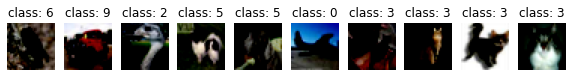

In [5]:
# dead kernel 잡기 ~ 라이브러리 충돌 방지
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1,10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i],(1,2,0)))
    plt.title('class: '+str(y_train[i].item()))

In [6]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3,
                               out_channels = 8, # filter 개수
                               kernel_size = 3,
                               padding = 1) # zero-padding
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, 
                               kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(8*8*16,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 8*8*16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        
        return x

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride= stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride= 1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes :
            self.shortcut = nn.Sequential(
                                nn.Conv2d(in_planes, planes, kernel_size=1,
                                          stride = stride, bias = False), # 이 예제에서는 bias 사용 안 하지만 후에 사용할 수도 있을 듯
                                nn.BatchNorm2d(planes)) 
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16,2,stride=1)
        self.layer2 = self._make_layer(32,2,stride=2)
        self.layer3 = self._make_layer(64,2,stride=2)
        self.linear = nn.Linear(64, num_classes)
    
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks -1) # [2] + [1]*2 == [2, 1, 1] // [1]이 뒤에 곱해진만큼 붙음
        #print(strides)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers) # list 요소가 하나씩 나옴, positional arguments / https://mingrammer.com/understanding-the-asterisk-of-python/
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [8]:
#model = cnn().to(DEVICE)
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)

[1, 1]
[2, 1]
[2, 1]
ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, 

In [9]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.415197
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.479891
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.398278
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.302660
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.302281
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 0.993781
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 0.848535
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 0.867174

[EPOCH: 1], 	Test Loss: 0.0316, 	Test Accuracy: 64.27 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 0.998176
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 0.862891
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 0.976455
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 0.635388
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.135755
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 0.926521
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.082609
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.752448

[EPOCH: 2], 	Test Loss: 0.0280, 	Test Accuracy: 68.12 % 